load data

In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


# data = pd.read_csv('updated_data (3).csv')
# data = pd.read_csv('newest with everythin.csv')
data = pd.read_csv('cleaned_cleaned_data_combined_modified (11).csv')
# data = pd.read_csv('cleaned_data.csv')
# data.describe()

seperate data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score


unique_labels = data["label"].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
data["label"] = data["label"].map(label_mapping)

X = data.drop(columns=["label"])
t = data["label"]

# Split into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, t_train, t_temp = train_test_split(X, t, test_size=0.3, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_temp, t_temp, test_size=0.5, random_state=42)


# Train Decision Tree Classifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth=8)
tree.fit(X_train, t_train)

# Compute Log Loss for validation set
t_val_proba = tree.predict_proba(X_val)
val_loss = log_loss(t_val, t_val_proba)
print(f"Validation Log Loss: {val_loss}")

# Compute Log Loss for test set
t_test_proba = tree.predict_proba(X_test)
test_loss = log_loss(t_test, t_test_proba)
print(f"Test Log Loss: {test_loss}")

# Compute Accuracy for validation and test sets
t_val_pred = tree.predict(X_val)
val_accuracy = accuracy_score(t_val, t_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

t_test_pred = tree.predict(X_test)
test_accuracy = accuracy_score(t_test, t_test_pred)
print(f"Test Accuracy: {test_accuracy}")


X_test.to_csv("X_test.csv", index=False)
t_test.to_csv("t_test.csv", index=False)

Validation Log Loss: 3.5151385847458316
Test Log Loss: 2.4335627336257546
Validation Accuracy: 0.7449392712550608
Test Accuracy: 0.8340080971659919


compare best hyper params

In [13]:
def build_all_models(max_depths,
                     min_samples_split,
                     criterion,
                     X_train=X_train,
                     t_train=t_train,
                     X_valid=X_val,
                     t_valid=t_val):
    """
    Parameters:
        `max_depths` - A list of values representing the max_depth values to be
                       try as hyperparameter values
        `min_samples_split` - An list of values representing the min_samples_split
                       values to try as hyperpareameter values
        `criterion` -  A string; either "entropy" or "gini"

    Returns a dictionary, `out`, whose keys are the the hyperparameter choices, and whose values are
    the training and validation accuracies (via the `score()` method).
    In other words, out[(max_depth, min_samples_split)]['val'] = validation score and
                    out[(max_depth, min_samples_split)]['train'] = training score
    For that combination of (max_depth, min_samples_split) hyperparameters.
    """
    out = {}

    for d in max_depths:
        for s in min_samples_split:
            out[(d, s)] = {}
            tree = DecisionTreeClassifier(max_depth=d, min_samples_split=s, criterion=criterion)
            tree.fit(X_train, t_train)

            # Store training and validation scores
            out[(d, s)]['train'] = tree.score(X_train, t_train)
            out[(d, s)]['val'] = tree.score(X_valid, t_valid)
    return out

In [14]:
criterions = ["entropy", "gini"]
max_depths = [1, 5, 10, 15, 20, 25, 30, 50, 100]
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

best_c = ""
best_d = 0
best_s = 0
for criterion in criterions:
    # print("\nUsing criterion {}".format(criterion))
    res = build_all_models(max_depths, min_samples_split, criterion)
    best = 0
    print(res)
    for d, s in res:
        if res[(d,s)]['val'] > best:
            best = res[(d, s)]['val']
            best_c = criterion
            best_d = d
            best_s = s
print("Best criterion: {}".format(best_c))
print("Best max depth: {}".format(best_d))
print("Best min samples split: {}".format(best_s))

{(1, 2): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 4): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 8): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 16): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 32): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 64): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 128): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 256): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 512): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (1, 1024): {'train': 0.5947826086956521, 'val': 0.5991902834008097}, (5, 2): {'train': 0.8660869565217392, 'val': 0.7894736842105263}, (5, 4): {'train': 0.8652173913043478, 'val': 0.7975708502024291}, (5, 8): {'train': 0.8652173913043478, 'val': 0.7894736842105263}, (5, 16): {'train': 0.8652173913043478, 'val': 0.805668016194332}, (5, 32): {'train': 0.8626086956521739, 'val': 0.805668016194332

grid search for random forest


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=50), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, t_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

clf = RandomForestClassifier(**best_params, random_state=42)
clf.fit(X_train, t_train)

# Compute Log Loss for validation set
t_val_proba = clf.predict_proba(X_val)
val_loss = log_loss(t_val, t_val_proba)
print(f"Validation Log Loss: {val_loss}")

# Compute Log Loss for test set
t_test_proba = clf.predict_proba(X_test)
test_loss = log_loss(t_test, t_test_proba)
print(f"Test Log Loss: {test_loss}")

# Compute Accuracy for validation and test sets
t_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(t_val, t_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

t_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(t_test, t_test_pred)
print(f"Test Accuracy: {test_accuracy}")


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Validation Log Loss: 0.4289975238406836
Test Log Loss: 0.3795148779094934
Validation Accuracy: 0.8744939271255061
Test Accuracy: 0.9271255060728745


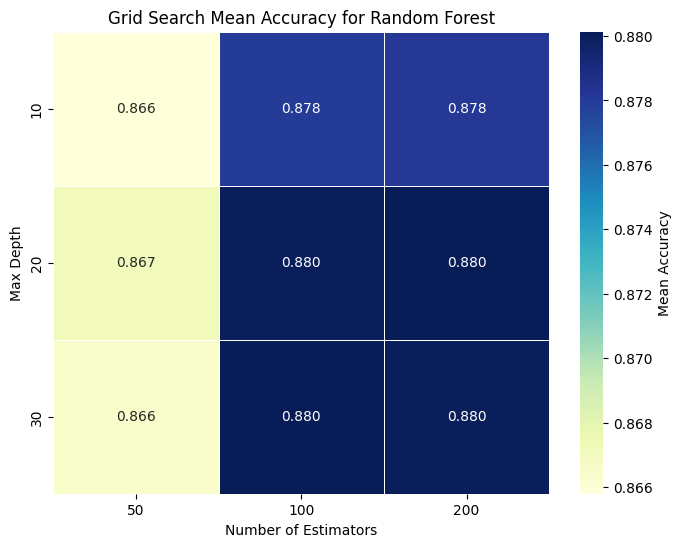

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get results from grid search
results = pd.DataFrame(grid_search.cv_results_)

pivot = results.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Mean Accuracy'}, linewidths=0.5)
plt.title('Grid Search Mean Accuracy for Random Forest')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

In [18]:
# tree = DecisionTreeClassifier(criterion="gini", min_samples_split=2, max_depth=5)
tree = RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=10, min_samples_leaf=1, max_depth=None, criterion='gini')

tree.fit(X_train, t_train)

# Compute Log Loss for validation set
t_val_proba = tree.predict_proba(X_val)
val_loss = log_loss(t_val, t_val_proba)
print(f"Validation Log Loss: {val_loss}")

# Compute Log Loss for test set
t_test_proba = tree.predict_proba(X_test)
test_loss = log_loss(t_test, t_test_proba)
print(f"Test Log Loss: {test_loss}")

# Compute Accuracy for validation and test sets
t_val_pred = tree.predict(X_val)
val_accuracy = accuracy_score(t_val, t_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

t_test_pred = tree.predict(X_test)
test_accuracy = accuracy_score(t_test, t_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Validation Log Loss: 0.4289975238406836
Test Log Loss: 0.3795148779094934
Validation Accuracy: 0.8744939271255061
Test Accuracy: 0.9271255060728745


NameError: name 'plt' is not defined

In [19]:
# Check the feature importance for Random Forest
feature_importance_rf = tree.feature_importances_

feature_importance_rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_rf
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Random Forest:")
print(feature_importance_rf_df)


Feature Importance for Random Forest:
            Feature  Importance
24    q3_at a party    0.103723
3        drink_coke    0.092391
73         avengers    0.070435
2                q4    0.070373
10   hot_sauce_none    0.049230
..              ...         ...
116             bud    0.000000
264           fault    0.000000
909          yakuza    0.000000
898           whole    0.000000
231   easternindian    0.000000

[919 rows x 2 columns]


Saved 200 trees as CSV files.


Forest in one csv

In [22]:
import pandas as pd
import os

def combine_trees_to_csv(input_prefix="tree_", output_file="random_forest.csv"):
    """Combine multiple decision tree CSV files into a single file."""
    tree_files = [f for f in os.listdir() if f.startswith(input_prefix) and f.endswith(".csv")]

    all_trees = []
    for i, file in enumerate(sorted(tree_files)):
        df = pd.read_csv(file)
        df["tree_id"] = i
        all_trees.append(df)

    combined_df = pd.concat(all_trees, ignore_index=True)
    combined_df.to_csv(output_file, index=False)
    print(f"Saved all trees into {output_file}")

# Run the function to merge all trees
combine_trees_to_csv()


Saved all trees into random_forest.csv


In [23]:
def load_forest_from_single_csv(filename="random_forest.csv"):
    """Load multiple trees from a single CSV file."""
    df = pd.read_csv(filename)
    forest = [df[df["tree_id"] == i].reset_index(drop=True) for i in df["tree_id"].unique()]
    return forest

# Load the single-file forest
forest_trees = load_forest_from_single_csv()


In [24]:
def predict_single(tree_df, sample):
    """Traverse the tree manually to classify a single sample."""
    node_id = 0

    while True:
        node = tree_df.loc[node_id]

        if node["feature"] == -2:
            values = np.fromstring(node["values"][1:-1], sep=" ")
            return np.argmax(values)

        feature_idx = int(node["feature"])
        threshold = node["threshold"]

        if sample[feature_idx] <= threshold:
            node_id = int(node["left_child"])
        else:
            node_id = int(node["right_child"])

def predict_forest(forest, X):
    """Predict multiple samples using majority voting from multiple trees."""
    predictions = np.array([predict_single(tree, x) for tree in forest for x in X.to_numpy()])
    predictions = predictions.reshape(len(forest), len(X))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# Load the single-file forest
forest_trees = load_forest_from_single_csv()

# Load test data
X_test = pd.read_csv("X_test.csv")
t_test = pd.read_csv("t_test.csv")["label"]

# Make predictions using majority voting
predictions = predict_forest(forest_trees, X_test)
print(predictions)
# Compute accuracy
accuracy = accuracy_score(t_test, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

n_classes = len(np.unique(t_test))
probs = np.zeros((len(t_test), n_classes))

for i, pred in enumerate(predictions):
    probs[i, pred] = 1

loss = log_loss(t_test, probs)
print(f"Test Log Loss: {loss:.4f}")

pd.DataFrame(predictions, columns=["Predicted"]).to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

[2 0 0 0 0 1 0 1 1 1 1 2 2 0 2 0 1 1 2 1 1 1 1 0 0 1 2 0 0 1 0 0 2 2 0 0 0
 2 1 2 2 2 1 1 2 0 0 0 1 2 2 1 0 1 1 1 2 1 2 1 1 1 1 2 0 1 2 1 1 0 2 0 1 2
 0 2 2 0 0 0 1 2 0 2 2 0 1 2 1 2 1 2 0 2 1 0 1 2 1 1 1 0 0 2 2 0 0 0 2 1 2
 1 0 2 1 2 0 1 1 1 2 2 2 1 1 2 0 2 1 2 0 1 2 1 2 1 1 2 2 0 0 0 2 2 2 2 1 1
 1 2 0 0 2 1 1 1 1 0 1 0 1 2 2 0 1 2 0 1 0 1 1 1 0 0 2 2 0 2 2 2 0 1 0 1 2
 2 2 2 1 1 2 0 2 0 1 1 0 1 1 0 1 1 1 0 1 2 1 1 1 0 0 2 2 1 1 2 2 1 2 1 2 0
 2 2 1 2 2 2 1 1 0 0 2 1 0 2 1 0 1 2 0 0 2 2 1 0 1]
Test Accuracy: 0.9231
Test Log Loss: 2.7726
Predictions saved to predictions.csv


In [ ]:
print(t_test)

0      2
1      0
2      0
3      0
4      0
      ..
242    2
243    1
244    1
245    0
246    1
Name: label, Length: 247, dtype: int64


individual CSVs

In [20]:
def save_forest_as_csv(forest, prefix="tree_"):
    """Save each tree in a Random Forest as a separate CSV file."""
    for i, tree in enumerate(forest.estimators_):
        filename = f"{prefix}{i}.csv"
        tree_structure = tree.tree_

        data = {
            "node_id": np.arange(tree_structure.node_count),
            "feature": tree_structure.feature,
            "threshold": tree_structure.threshold,
            "left_child": tree_structure.children_left,
            "right_child": tree_structure.children_right,
            "values": [v[0] for v in tree_structure.value],
        }

        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)

    print(f"Saved {len(forest.estimators_)} trees as CSV files.")

save_forest_as_csv(clf, prefix="tree_")

Saved 200 trees as CSV files.


In [21]:
import pandas as pd
import numpy as np
import os

def load_forest_from_csv(prefix="tree_"):
    """Load multiple decision trees from CSV files into a list of DataFrames."""
    tree_files = [f for f in os.listdir() if f.startswith(prefix) and f.endswith(".csv")]
    return [pd.read_csv(f) for f in sorted(tree_files)]

def predict_single(tree_df, sample):
    """Traverse the tree manually to classify a single sample."""
    node_id = 0

    while True:
        node = tree_df.loc[node_id]

        if node["feature"] == -2:
            values = np.fromstring(node["values"][1:-1], sep=" ")
            return np.argmax(values)

        feature_idx = int(node["feature"])
        threshold = node["threshold"]

        if sample[feature_idx] <= threshold:
            node_id = int(node["left_child"])
        else:
            node_id = int(node["right_child"])

def predict_forest(forest, X):
    """Predict multiple samples using majority voting from multiple trees."""
    predictions = np.array([predict_single(tree, x) for tree in forest for x in X.to_numpy()])
    predictions = predictions.reshape(len(forest), len(X))
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# Load all trees in the saved forest
forest_trees = load_forest_from_csv()

# Load test data
X_test = pd.read_csv("X_test.csv")
t_test = pd.read_csv("t_test.csv")["label"]

predictions = predict_forest(forest_trees, X_test)

pd.DataFrame(predictions, columns=["Predicted"]).to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

# Compute and print accuracy
accuracy = np.mean(predictions == t_test.to_numpy())
print(f"Test Accuracy: {accuracy:.4f}")


KeyboardInterrupt: 

In [ ]:
"""
This Python file is example of how your `pred.py` script should
look. Your file should contain a function `predict_all` that takes
in the name of a CSV file, and returns a list of predictions.

Your `pred.py` script can use different methods to process the input
data, but the format of the input it takes and the output your script produces should be the same.

Here's an example of how your script may be used in our test file:

    from example_pred import predict_all
    predict_all("example_test_set.csv")
"""
import pandas as pd
import numpy as np
import re
from collections import Counter

def process_q2(text):
    if pd.isnull(text):
        return None
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
import pandas as pd
import numpy as np
import re
from collections import Counter


def load_forest_from_single_csv(filename="random_forest.csv"):
    """Load multiple trees from a single CSV file."""
    df = pd.read_csv(filename)
    forest = [df[df["tree_id"] == i].reset_index(drop=True) for i in df["tree_id"].unique()]
    return forest

def predict(x):
    """
    Helper function to make prediction for a given input x.
    This code is here for demonstration purposes only.
    """
    return y

def predict_single(tree_df, sample):
    """Traverse the tree manually to classify a single sample."""
    node_id = 0  # Start at the root

    while True:
        node = tree_df.loc[node_id]

        if node["feature"] == -2:  # Leaf node
            values = np.fromstring(node["values"][1:-1], sep=" ")  # Convert string to array
            return np.argmax(values)  # Class with highest count

        feature_idx = int(node["feature"])
        threshold = node["threshold"]

        # Add bounds checking
        if feature_idx >= len(sample):
            # If feature index is out of bounds, go to the left child as default
            node_id = int(node["left_child"])
            continue

        if sample[feature_idx] <= threshold:
            node_id = int(node["left_child"])
        else:
            node_id = int(node["right_child"])

def predict_forest(forest, X):
    """Predict multiple samples using majority voting from multiple trees."""
    # Convert DataFrame to numpy array if it isn't already
    X_array = X.to_numpy()

    # Make predictions for each tree and sample
    all_predictions = []
    for tree in forest:
        tree_predictions = []
        for x in X_array:
            pred = predict_single(tree, x)
            tree_predictions.append(pred)
        all_predictions.append(tree_predictions)

    predictions = np.array(all_predictions)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

def predict_all(filename):
    """
    Make predictions for the data in filename
    """
    # Define label mapping
    label_map = {
        0: 'Pizza',
        1: 'Shawarma',
        2: 'Sushi'
    }

    # Clean and load data
    cleaned_data = clean_and_process_csv(filename)
    data = pd.read_csv(cleaned_data)

    if 'label' in data.columns:
        data = data.drop(columns=['label'])

    # Load forest and make predictions
    forest_trees = load_forest_from_single_csv()
    predictions = predict_forest(forest_trees, data)

    # Map numeric predictions to label names
    preds = [label_map[p] for p in predictions]

    return preds

# Load test data
X_test = pd.read_csv("X_test.csv")
t_test = pd.read_csv("t_test.csv")["label"]  # Load true labels

# Make predictions using the trained forest
predictions = predict_forest(load_forest_from_single_csv(), X_test)

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == t_test.to_numpy())
print(f"Accuracy: {accuracy * 100:.2f}%")

    numbers = [float(num) for num in numbers]
    filtered_numbers = [num for num in numbers if 1 <= num <= 10]
    if filtered_numbers:
        result = sum(filtered_numbers) / len(filtered_numbers)
    elif ',' in text:
        return text.count(',') + 1
    else:
        result = len(text) / 5
    return np.ceil(result)

def extract_numeric(value):
    if isinstance(value, str):
        value = value.lower().strip()
        numbers = re.findall(r'\d+', value)
        if numbers:
            return int(numbers[0])
        return "unknown"
    return value

def clean_drink(value):
    drink_map = {
        "coke": ["coke", "cola", "diet coke", "pepsi", "diet pepsi", "soda", "pop", "soft", "fanta", "sprite", "ginger"],
        "juice": ["juice", "nestea", "lemonade"],
        "tea": ["tea", "matcha"],
        "milk": ["ayran", "milk", "dairy"],
        "beer": ["beer", "wine", "alcoholic", "sake", "soju"],
        "water": ["water"],
        "soup": ["miso", "soup"]
    }
    if isinstance(value, str):
        value = re.sub(r'[^a-z0-9 ]', '', value.lower().strip())
        for category, keywords in drink_map.items():
            if any(keyword in value for keyword in keywords):
                return category
    return "unknown"

def one_hot_encode(df, column_name, categories):
    if column_name in df.columns:
        df[column_name] = df[column_name].str.lower().str.strip()
        df[column_name] = df[column_name].apply(lambda x: x.split(",") if isinstance(x, str) else [])
        for category in categories:
            df[f"{column_name}_{category}"] = df[column_name].apply(lambda x: 1 if category in x else 0)
        df.drop(columns=[column_name], inplace=True)
    return df

def clean_and_process_csv(file_path):
    df = pd.read_csv(file_path, dtype=str)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    df = df.drop_duplicates().fillna("unknown")

    # Process Q2
    q2_col = "q2:_how_many_ingredients_would_you_expect_this_food_item_to_contain?"
    if q2_col in df.columns:
        df['q2'] = df[q2_col].apply(process_q2)

    # Process Q4
    q4_col = "q4:_how_much_would_you_expect_to_pay_for_one_serving_of_this_food_item?"
    if q4_col in df.columns:
        df['q4'] = df[q4_col].apply(extract_numeric)

    # Process Q6
    q6_col = "q6:_what_drink_would_you_pair_with_this_food_item?"
    if q6_col in df.columns:
        df['q6'] = df[q6_col].apply(clean_drink)
        for cat in ["coke", "juice", "tea", "milk", "beer", "water", "soup"]:
            df[f'drink_{cat}'] = df['q6'].apply(lambda x: 1 if x == cat else 0)
        df.drop(columns=['q6'], inplace=True)

    # Process Q8
    q8_col = "q8:_how_much_hot_sauce_would_you_add_to_this_food_item?"
    if q8_col in df.columns:
        df['q8'] = df[q8_col].apply(lambda x: re.search(r"\((.*?)\)", x).group(1) if re.search(r"\((.*?)\)", x) else None)
        for category in ["none", "mild", "medium", "hot"]:
            df[f'hot_sauce_{category}'] = df['q8'].apply(lambda x: 1 if x == category else 0)
        df.drop(columns=['q8'], inplace=True)

    # Process Q7 and Q3 with one-hot encoding
    df = one_hot_encode(df, "q7:_when_you_think_about_this_food_item,_who_does_it_remind_you_of?",
                        ["parents", "siblings", "friends", "teachers", "strangers"])
    df = one_hot_encode(df, "q3:_in_what_setting_would_you_expect_this_food_to_be_served?_please_check_all_that_apply",
                        ["week day lunch", "week day dinner", "weekend lunch", "weekend dinner", "at a party", "late night snack"])

    # Process Q5 - Bag of Words
    text_column = "q5:_what_movie_do_you_think_of_when_thinking_of_this_food_item?"
    word_counts = Counter()
    stop_words = set("i me my myself we our ours you your they them their what which who this that these those am is are was were be been being have has had do does did doing a an the and but if or because as until while of at by for with about between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most some such no nor not only own same so than too very s t can will just don should now d ll m o re ve y".split())
    if text_column in df.columns:
        df[text_column] = df[text_column].apply(lambda text: [word for word in text.lower().strip().split() if word not in stop_words] if isinstance(text, str) else [])
        for words in df[text_column]:
            word_counts.update(words)
        unique_words = sorted(word_counts.keys())
        bow_df = pd.DataFrame(0, index=df.index, columns=unique_words)
        for idx, words in enumerate(df[text_column]):
            for word in words:
                bow_df.at[idx, word] = 1
        df.drop(columns=[text_column], inplace=True)
        df = pd.concat([df, bow_df], axis=1)

    # Replace non-numeric values with 0 except for 'label'
    for column in df.columns:
        if column != "label":
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0)

    # Drop unnecessary columns
    df.drop(columns=['id'], errors='ignore', inplace=True)
    if len(df.columns) > 4:
        df.drop(columns=df.columns[1:5], errors='ignore', inplace=True)

    output_path = "cleaned_" + file_path
    df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved to {output_path}")
    return output_path






# Example usage:
# cleaned_file = clean_and_process_csv("cleaned_data_combined_modified.csv")
def load_forest_from_single_csv(filename="random_forest.csv"):
    """Load multiple trees from a single CSV file."""
    df = pd.read_csv(filename)
    forest = [df[df["tree_id"] == i].reset_index(drop=True) for i in df["tree_id"].unique()]
    return forest

def predict(x):
    """
    Helper function to make prediction for a given input x.
    This code is here for demonstration purposes only.
    """

    return y

def predict_single(tree_df, sample):
    """Traverse the tree manually to classify a single sample."""
    node_id = 0  # Start at the root

    while True:
        node = tree_df.loc[node_id]

        if node["feature"] == -2:  # Leaf node
            values = np.fromstring(node["values"][1:-1], sep=" ")  # Convert string to array
            return np.argmax(values)  # Class with highest count

        feature_idx = int(node["feature"])
        threshold = node["threshold"]

        # Add bounds checking
        if feature_idx >= len(sample):
            # If feature index is out of bounds, go to the left child as default
            node_id = int(node["left_child"])
            continue

        if sample[feature_idx] <= threshold:
            node_id = int(node["left_child"])
        else:
            node_id = int(node["right_child"])

def predict_forest(forest, X):
    """Predict multiple samples using majority voting from multiple trees."""
    # Convert DataFrame to numpy array if it isn't already
    X_array = X.to_numpy()

    # Make predictions for each tree and sample
    all_predictions = []
    for tree in forest:
        tree_predictions = []
        for x in X_array:
            pred = predict_single(tree, x)
            tree_predictions.append(pred)
        all_predictions.append(tree_predictions)

    predictions = np.array(all_predictions)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

def predict_all(filename):
    """
    Make predictions for the data in filename
    """
    # Define label mapping
    label_map = {
        0: 'Pizza',
        1: 'Shawarma',
        2: 'Sushi'
    }

    # Clean and load data
    cleaned_data = clean_and_process_csv(filename)
    data = pd.read_csv(cleaned_data)

    if 'label' in data.columns:
        data = data.drop(columns=['label'])

    # Load forest and make predictions
    forest_trees = load_forest_from_single_csv()
    predictions = predict_forest(forest_trees, data)

    # Map numeric predictions to label names
    preds = [label_map[p] for p in predictions]

    return preds


predict_all("cleaned_data_combined_modified.csv")

Cleaned dataset saved to cleaned_cleaned_data_combined_modified.csv


KeyboardInterrupt: 